In [14]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [65]:
# ---------------- CONFIG ----------------
V_CUTOFF = 2.7
CAPACITY_MIN_AH = 1.0
NOMINAL_AH = 2.0

BINS = 20
M_RESAMPLE = 200

# Loss weights
LAMBDA_Q = 0.3
LAMBDA_E = 0.3
LAMBDA_PHYSICS = 0.7  # NEW: Weight for SPM physics loss

BATCH_SIZE = 64
EPOCHS = 60
LR = 5e-5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}","Device:",torch.cuda.get_device_name(0))

# SPM Physical Parameters
F = 96485.0         # Faraday constant (C/mol)
R = 8.314           # Gas constant (J/mol/K)
T_REF = 298.15      # Reference temperature (K)
A_CELL = 0.1027     # Electrode area (m^2)

# Default SPM parameters (will be predicted by model)
D_S_POS_DEFAULT = 1e-14  # Positive electrode diffusion coeff (m^2/s)
D_S_NEG_DEFAULT = 3e-14  # Negative electrode diffusion coeff (m^2/s)
R_P_POS_DEFAULT = 2e-6   # Positive particle radius (m)
R_P_NEG_DEFAULT = 2e-6   # Negative particle radius (m)
C_S_MAX_POS = 51555.0    # Max concentration positive (mol/m^3)
C_S_MAX_NEG = 30555.0    # Max concentration negative (mol/m^3)

Using device: cuda Device: Tesla P100-PCIE-16GB


## Data Loading and Preprocessing

In [18]:
metadata = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv")

print(metadata.head())
print("\nColumns:", metadata.columns.tolist())
print("\nType distribution:")
print(metadata["type"].value_counts())

        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5  00005.csv   

             Capacity                   Re                  Rct  
0  1.6743047446975208                  NaN                  NaN  
1                 NaN  0.05605783343888099  0.20097016584458333  
2                 NaN     

In [19]:
excluded_batteries = ["B0049", "B0050", "B0051", "B0052"]

metadata["battery_id"] = metadata["battery_id"].astype(str)

discharge_meta = metadata[
    (metadata["type"] == "discharge") &
    (~metadata["battery_id"].isin(excluded_batteries))
].copy()

discharge_meta["cycle_number"] = (
    discharge_meta.groupby("battery_id").cumcount() + 1
)

print(f"Total discharge cycles: {len(discharge_meta)}")

Total discharge cycles: 2694


In [29]:
# Extract resistance from impedance tests
impedance_data = metadata[metadata["type"] == "impedance"].copy()
impedance_data = impedance_data[~impedance_data["battery_id"].isin(excluded_batteries)]

# Convert string columns to numeric, handling any non-numeric values
impedance_data["Re"] = pd.to_numeric(impedance_data["Re"], errors='coerce')
impedance_data["Rct"] = pd.to_numeric(impedance_data["Rct"], errors='coerce')

# Calculate total resistance: Re (electrolyte) + Rct (charge transfer)
impedance_data["R_total_measured"] = impedance_data["Re"] + impedance_data["Rct"]

# Remove NaN values
impedance_data = impedance_data.dropna(subset=["R_total_measured"])

print(f"Found {len(impedance_data)} impedance measurements")
print(f"Resistance range: {impedance_data['R_total_measured'].min():.4f} - {impedance_data['R_total_measured'].max():.4f} Ω")
print(f"Mean resistance: {impedance_data['R_total_measured'].mean():.4f} ± {impedance_data['R_total_measured'].std():.4f} Ω")

# Create a mapping from battery_id to resistance values
resistance_map = {}
for bid in impedance_data["battery_id"].unique():
    bid_data = impedance_data[impedance_data["battery_id"] == bid]
    # Take median resistance for each battery
    resistance_map[bid] = bid_data["R_total_measured"].median()

print(f"\nResistance values for {len(resistance_map)} batteries")
print("Sample:", {k: f"{v:.4f}" for k, v in list(resistance_map.items())[:3]})

Found 1908 impedance measurements
Resistance range: 0.0677 - 0.3528 Ω
Mean resistance: 0.1968 ± 0.0675 Ω

Resistance values for 30 batteries
Sample: {'B0047': '0.2866', 'B0045': '0.3111', 'B0048': '0.3121'}


In [30]:
main_rows = []
phys_rows = []

for _, row in tqdm(discharge_meta.iterrows(), total=len(discharge_meta), desc="Processing cycles"):
    file_path = os.path.join(
        "/kaggle/input/nasa-battery-dataset/cleaned_dataset/data",
        row["filename"]
    )
    df = pd.read_csv(file_path)

    # Sort & deduplicate
    df = df.sort_values("Time").drop_duplicates("Time")
    if len(df) < 5:
        continue

    # Voltage cutoff
    cutoff_idx = df[df["Voltage_measured"] < V_CUTOFF].index.min()
    if not pd.isna(cutoff_idx):
        df = df.loc[:cutoff_idx]

    if len(df) < 5:
        continue

    # Coulomb counting
    dt_hr_raw = df["Time"].diff().fillna(0) / 3600.0
    dQ = df["Current_measured"] * dt_hr_raw
    capacity = abs(dQ.sum())

    if capacity < CAPACITY_MIN_AH or capacity > NOMINAL_AH:
        continue

    # SoC & SoH
    CumQ = dQ.cumsum()
    df["SoC"] = 100.0 * (1.0 + CumQ / capacity)
    soh = 100.0 * capacity / NOMINAL_AH
    
    # Get measured resistance for this battery (NEW!)
    bid = row["battery_id"]
    R_measured = resistance_map.get(bid, 0.08)  # Default if not available

    # -------- RESAMPLING (physics) --------
    t = df["Time"].to_numpy()
    t0, t1 = t[0], t[-1]
    if t1 <= t0:
        continue

    t_grid = np.linspace(t0, t1, M_RESAMPLE)
    dt_hr = np.diff(t_grid, prepend=t_grid[0]) / 3600.0

    def interp(col):
        return np.interp(t_grid, t, df[col].to_numpy())

    V = interp("Voltage_measured")
    I = interp("Current_measured")
    T = interp("Temperature_measured")
    SoC = interp("SoC")

    for j in range(M_RESAMPLE):
        phys_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "t_idx": j,
            "dt_hr": dt_hr[j],
            "Voltage": V[j],
            "Current": I[j],
            "Temperature": T[j],
            "SoC": SoC[j],
            "Capacity_Ah": capacity,
            "SoH": soh,
            "R_measured": R_measured  # NEW: Add measured resistance
        })

    # -------- BINNING (ML input) --------
    rs = pd.DataFrame({
        "dt_hr": dt_hr,
        "Voltage": V,
        "Current": I,
        "Temperature": T,
        "SoC": SoC
    })

    chunks = np.array_split(rs, BINS)
    if any(c.empty for c in chunks):
        continue

    for b, c in enumerate(chunks):
        main_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "bin": b,
            "dt_hr": c["dt_hr"].sum(),
            "Voltage": c["Voltage"].mean(),
            "Current": c["Current"].mean(),
            "Temperature": c["Temperature"].mean(),
            "SoC": c["SoC"].mean(),
            "Capacity_Ah": capacity,
            "SoH": soh,
            "R_measured": R_measured  # NEW: Add measured resistance
        })

main_df = pd.DataFrame(main_rows)
phys_df = pd.DataFrame(phys_rows)

print(f"\nMain DF shape: {main_df.shape}")
print(f"Physics DF shape: {phys_df.shape}")
print(f"\nResistance statistics:")
print(f"  Mean: {main_df['R_measured'].mean():.4f} Ω")
print(f"  Std:  {main_df['R_measured'].std():.4f} Ω")

Processing cycles: 100%|██████████| 2694/2694 [00:28<00:00, 95.68it/s] 



Main DF shape: (45660, 11)
Physics DF shape: (456600, 11)

Resistance statistics:
  Mean: 0.2141 Ω
  Std:  0.0648 Ω


In [31]:
print("Main DataFrame sample:")
display(main_df.head())

print("\nPhysics DataFrame sample:")
display(phys_df.head())

Main DataFrame sample:


,battery_id,cycle_number,bin,dt_hr,Voltage,Current,Temperature,SoC,Capacity_Ah,SoH,R_measured
0,B0047,1,0,0.076280,3.973249,-0.895922,5.696895,97.874331,1.676224,83.811222,0.286591
1,B0047,1,1,0.084756,3.846693,-0.995426,6.313496,92.857632,1.676224,83.811222,0.286591
2,B0047,1,2,0.084756,3.799699,-0.995378,7.502362,87.823951,1.676224,83.811222,0.286591
3,B0047,1,3,0.084756,3.752450,-0.995080,8.297468,82.790637,1.676224,83.811222,0.286591
4,B0047,1,4,0.084756,3.702428,-0.995301,7.490656,77.758480,1.676224,83.811222,0.286591



Physics DataFrame sample:


,battery_id,cycle_number,t_idx,dt_hr,Voltage,Current,Temperature,SoC,Capacity_Ah,SoH,R_measured
0,B0047,1,0,0.000000,4.246711,0.000252,6.212696,100.000000,1.676224,83.811222,0.286591
1,B0047,1,1,0.008476,4.028385,-0.995996,6.278860,99.650780,1.676224,83.811222,0.286591
2,B0047,1,2,0.008476,3.994477,-0.995535,6.394532,99.147795,1.676224,83.811222,0.286591
3,B0047,1,3,0.008476,3.970792,-0.997871,5.960556,98.643951,1.676224,83.811222,0.286591
4,B0047,1,4,0.008476,3.951566,-0.993963,5.709974,98.141356,1.676224,83.811222,0.286591


## SPM Physics Module

The Single Particle Model (SPM) is a simplified electrochemical model that treats each electrode as a single spherical particle. The key equations are:

1. **Surface concentration dynamics** (simplified):
   $$c_{s,surf} = c_{s,0} - \frac{I \cdot t}{n \cdot F \cdot A \cdot L \cdot \epsilon_s}$$

2. **Terminal voltage**:
   $$V = U_{pos}(\theta_{pos}) - U_{neg}(\theta_{neg}) - I \cdot R_{total}$$

where $\theta = c_s / c_{s,max}$ is the stoichiometry.

In [34]:
class SPMPhysics(nn.Module):
    """Simplified Single Particle Model for voltage prediction"""
    
    def __init__(self):
        super().__init__()
        
    def ocv_pos(self, theta):
        """Open circuit voltage for positive electrode (LiCoO2)"""
        # Simplified OCV curve
        theta = torch.clamp(theta, 0.4, 0.99)
        U = 4.2 - 0.5 * theta + 0.1 * torch.sin(10 * theta)
        return U
    
    def ocv_neg(self, theta):
        """Open circuit voltage for negative electrode (Graphite)"""
        # Simplified OCV curve
        theta = torch.clamp(theta, 0.01, 0.9)
        U = 0.16 + 0.2 * theta - 0.15 * torch.sin(8 * theta)
        return U
    
    def forward(self, current, dt, soc, spm_params, temperature=298.15):
        """
        Predict voltage trajectory using SPM equations
        
        Args:
            current: [batch, time] - current profile (A)
            dt: [batch, time] - time steps (hours)
            soc: [batch, time] - state of charge (0-1)
            spm_params: dict with keys:
                - R_total: [batch] - total resistance (Ohm)
                - theta_pos_0: [batch] - initial positive stoichiometry
                - theta_neg_0: [batch] - initial negative stoichiometry
                - Q_nom: [batch] - nominal capacity (Ah)
            temperature: [batch, time] - temperature (K)
        
        Returns:
            voltage: [batch, time] - predicted voltage
        """
        batch_size, time_steps = current.shape
        
        # Extract parameters
        R_total = spm_params['R_total'].unsqueeze(1)  # [batch, 1]
        theta_pos_0 = spm_params['theta_pos_0'].unsqueeze(1)
        theta_neg_0 = spm_params['theta_neg_0'].unsqueeze(1)
        Q_nom = spm_params['Q_nom'].unsqueeze(1)
        
        # Convert dt from hours to seconds
        dt_sec = dt * 3600.0
        
        # Compute stoichiometry from SoC
        # Discharge: theta_pos increases, theta_neg decreases
        delta_theta = (1.0 - soc) * 0.5  # Simplified mapping
        theta_pos = theta_pos_0 + delta_theta
        theta_neg = theta_neg_0 - delta_theta
        
        # Clamp to valid ranges
        theta_pos = torch.clamp(theta_pos, 0.4, 0.99)
        theta_neg = torch.clamp(theta_neg, 0.01, 0.9)
        
        # Compute OCV
        U_pos = self.ocv_pos(theta_pos)
        U_neg = self.ocv_neg(theta_neg)
        V_ocv = U_pos - U_neg
        
        # Ohmic drop
        V_ohm = current * R_total
        
        # Terminal voltage
        voltage = V_ocv - V_ohm
        
        return voltage

## Enhanced Dataset with Physics Support

In [35]:
class BatteryDatasetWithPhysics(Dataset):
    def __init__(self, main_df, phys_df):
        self.main_df = main_df
        self.phys_df = phys_df
        self.keys = main_df[["battery_id", "cycle_number"]].drop_duplicates().values

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        bid, cyc = self.keys[idx]

        # Main features (binned)
        x = self.main_df[
            (self.main_df.battery_id == bid) &
            (self.main_df.cycle_number == cyc)
        ].sort_values("bin")

        # Physics time series
        p = self.phys_df[
            (self.phys_df.battery_id == bid) &
            (self.phys_df.cycle_number == cyc)
        ].sort_values("t_idx")

        # Transformer input (binned features)
        X = torch.tensor(
            x[["Voltage","Current","Temperature","SoC","dt_hr"]].values,
            dtype=torch.float32
        )

        # Physics time series
        V_meas = torch.tensor(p["Voltage"].values, dtype=torch.float32)
        I_meas = torch.tensor(p["Current"].values, dtype=torch.float32)
        T_meas = torch.tensor(p["Temperature"].values + 273.15, dtype=torch.float32)  # Convert to K
        SoC_ts = torch.tensor(p["SoC"].values / 100.0, dtype=torch.float32)  # Normalize to 0-1
        dt_ts = torch.tensor(p["dt_hr"].values, dtype=torch.float32)
        
        # NEW: Measured resistance (from impedance tests)
        R_measured = torch.tensor(p["R_measured"].iloc[0], dtype=torch.float32)

        # Targets
        Q_true = torch.tensor(
            abs((p["Current"] * p["dt_hr"]).sum()),
            dtype=torch.float32
        )

        E_true = torch.tensor(
            abs((p["Voltage"] * p["Current"] * p["dt_hr"]).sum()),
            dtype=torch.float32
        )

        SoH = torch.tensor(x["SoH"].iloc[0] / 100.0, dtype=torch.float32)
        Q_true = Q_true / NOMINAL_AH
        E_true = E_true / 10.0
        
        # Return 10 outputs now (added R_measured)
        return X, Q_true, E_true, SoH, V_meas, I_meas, T_meas, SoC_ts, dt_ts, R_measured

## Physics-Informed Transformer Model

In [37]:
class PhysicsInformedTransformer(nn.Module):
    def __init__(self, d_in=5, d_model=64, nhead=4, nlayers=3):
        super().__init__()
        self.embed = nn.Linear(d_in, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, nlayers)

        # Original heads
        self.head_soh = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
        self.head_q = nn.Linear(d_model, 1)
        self.head_e = nn.Linear(d_model, 1)
        
        # SPM parameter heads
        self.head_resistance = nn.Sequential(
            nn.Linear(d_model, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Softplus()  # Ensure positive
        )
        
        self.head_theta_pos = nn.Sequential(
            nn.Linear(d_model, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # 0-1 range
        )
        
        self.head_theta_neg = nn.Sequential(
            nn.Linear(d_model, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # 0-1 range
        )
        
        # SPM physics module
        self.spm = SPMPhysics()

    def forward(self, x):
        z = self.embed(x)
        z = self.encoder(z)
        z = z.mean(dim=1)  # [batch, d_model]

        # Original outputs
        soh = self.head_soh(z).squeeze(-1)
        q = self.head_q(z).squeeze(-1)
        e = self.head_e(z).squeeze(-1)
        
        # SPM parameters
        R_total = self.head_resistance(z).squeeze(-1) * 0.1 + 0.01  # Scale: 0.01-0.11 Ohm
        theta_pos_0 = self.head_theta_pos(z).squeeze(-1) * 0.4 + 0.5  # Scale: 0.5-0.9
        theta_neg_0 = self.head_theta_neg(z).squeeze(-1) * 0.3 + 0.1  # Scale: 0.1-0.4
        
        spm_params = {
            'R_total': R_total,
            'theta_pos_0': theta_pos_0,
            'theta_neg_0': theta_neg_0,
            'Q_nom': torch.ones_like(R_total) * NOMINAL_AH
        }

        return soh, q, e, spm_params
    
    def predict_voltage(self, x, current, dt, soc, temperature):
        """Predict voltage using learned SPM parameters"""
        _, _, _, spm_params = self.forward(x)
        voltage = self.spm(current, dt, soc, spm_params, temperature)
        return voltage

## Training Setup

In [38]:
# Create dataset
dataset = BatteryDatasetWithPhysics(main_df, phys_df)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True,
    pin_memory=True if DEVICE == "cuda" else False
)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(loader)}")

Dataset size: 2283
Number of batches: 36


In [39]:
# Initialize model
model = PhysicsInformedTransformer(d_model=64, nhead=4, nlayers=3).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
mse = nn.MSELoss()

print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# Checkpoint directory
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Model parameters: 0.85M


In [66]:
best_ckpt = torch.load(os.path.join(CHECKPOINT_DIR, "physics_transformer_best.pt"), map_location=DEVICE)
model.load_state_dict(best_ckpt["model_state_dict"])

start_epoch =35

print(f"🔁 Resumed training from epoch {start_epoch}")


🔁 Resumed training from epoch 35


In [67]:
# Training history
print("Resuming training from epoch:",{start_epoch})
loss_hist = {
    'total': [],
    'soh': [],
    'q': [],
    'e': [],
    'physics': [],
    'resistance': []  # NEW: Track resistance loss
}

best_loss = float('inf')

for epoch in range(start_epoch,EPOCHS):
    model.train()
    epoch_losses = {'total': 0.0, 'soh': 0.0, 'q': 0.0, 'e': 0.0, 'physics': 0.0, 'resistance': 0.0}

    pbar = tqdm(
        loader,
        desc=f"Epoch [{epoch+1}/{EPOCHS}]",
        leave=False
    )

    for batch_data in pbar:
        X, Q, E, SoH, V_meas, I_meas, T_meas, SoC_ts, dt_ts, R_measured = batch_data
        
        # Move to device
        X = X.to(DEVICE, non_blocking=True)
        Q = Q.to(DEVICE, non_blocking=True)
        E = E.to(DEVICE, non_blocking=True)
        SoH = SoH.to(DEVICE, non_blocking=True)
        V_meas = V_meas.to(DEVICE, non_blocking=True)
        I_meas = I_meas.to(DEVICE, non_blocking=True)
        T_meas = T_meas.to(DEVICE, non_blocking=True)
        SoC_ts = SoC_ts.to(DEVICE, non_blocking=True)
        dt_ts = dt_ts.to(DEVICE, non_blocking=True)
        R_measured = R_measured.to(DEVICE, non_blocking=True)

        opt.zero_grad()

        # Forward pass
        SoH_p, Q_p, E_p, spm_params = model(X)

        # Data-driven losses
        loss_soh = mse(SoH_p, SoH)
        loss_q = mse(Q_p, Q)
        loss_e = mse(E_p, E)
        
        # NEW: Resistance constraint loss (learned R should match measured R)
        loss_resistance = mse(spm_params['R_total'], R_measured)

        # Physics loss: SPM voltage prediction
        V_pred = model.spm(I_meas, dt_ts, SoC_ts, spm_params, T_meas)
        loss_physics = mse(V_pred, V_meas)

        # Total loss (added resistance term)
        loss = loss_soh + LAMBDA_Q * loss_q + LAMBDA_E * loss_e + LAMBDA_PHYSICS * loss_physics + 0.3 * loss_resistance
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        # Accumulate losses
        epoch_losses['total'] += loss.item()
        epoch_losses['soh'] += loss_soh.item()
        epoch_losses['q'] += loss_q.item()
        epoch_losses['e'] += loss_e.item()
        epoch_losses['physics'] += loss_physics.item()
        epoch_losses['resistance'] += loss_resistance.item()

        pbar.set_postfix({
            "L_tot": f"{loss.item():.4f}",
            "L_soh": f"{loss_soh.item():.4f}",
            "L_phys": f"{loss_physics.item():.4f}",
            "L_R": f"{loss_resistance.item():.4f}"
        })

    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= len(loader)
        loss_hist[key].append(epoch_losses[key])
    
    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Total: {epoch_losses['total']:.4f} | "
          f"SoH: {epoch_losses['soh']:.4f} | "
          f"Physics: {epoch_losses['physics']:.4f} | "
          f"R_loss: {epoch_losses['resistance']:.4f} | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

    # Save checkpoint every 5 epochs or if best
    if (epoch + 1) % 5 == 0 or epoch_losses['total'] < best_loss:
        if epoch_losses['total'] < best_loss:
            best_loss = epoch_losses['total']
            save_name = "physics_transformer_best.pt"
        else:
            save_name = f"physics_transformer_epoch_{epoch+1}.pt"
        
        save_path = os.path.join(CHECKPOINT_DIR, save_name)
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": opt.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "loss": epoch_losses['total'],
            "loss_hist": loss_hist
        }, save_path)
        print(f"Saved: {save_name}")

print("\nTraining complete!")

Resuming training from epoch: {35}


Epoch 36/60 | Total: 0.0923 | SoH: 0.0031 | Physics: 0.1068 | R_loss: 0.0420 | LR: 0.000033
Saved: physics_transformer_best.pt


Epoch 37/60 | Total: 0.0916 | SoH: 0.0031 | Physics: 0.1056 | R_loss: 0.0422 | LR: 0.000040
Saved: physics_transformer_best.pt


Epoch 38/60 | Total: 0.0911 | SoH: 0.0031 | Physics: 0.1047 | R_loss: 0.0424 | LR: 0.000045
Saved: physics_transformer_best.pt


Epoch 39/60 | Total: 0.0901 | SoH: 0.0030 | Physics: 0.1035 | R_loss: 0.0426 | LR: 0.000049
Saved: physics_transformer_best.pt


Epoch 40/60 | Total: 0.0892 | SoH: 0.0029 | Physics: 0.1024 | R_loss: 0.0428 | LR: 0.000050
Saved: physics_transformer_best.pt


Epoch 41/60 | Total: 0.0887 | SoH: 0.0029 | Physics: 0.1015 | R_loss: 0.0431 | LR: 0.000049
Saved: physics_transformer_best.pt


Epoch 42/60 | Total: 0.0881 | SoH: 0.0028 | Physics: 0.1009 | R_loss: 0.0432 | LR: 0.000045
Saved: physics_transformer_best.pt


Epoch 43/60 | Total: 0.0881 | SoH: 0.0028 | Physics: 0.1004 | R_loss: 0.0433 | LR: 0.000040
Saved: physics_transformer_best.pt


Epoch 44/60 | Total: 0.0872 | SoH: 0.0028 | Physics: 0.0996 | R_loss: 0.0435 | LR: 0.000033
Saved: physics_transformer_best.pt


Epoch 45/60 | Total: 0.0871 | SoH: 0.0029 | Physics: 0.0992 | R_loss: 0.0435 | LR: 0.000025
Saved: physics_transformer_best.pt


Epoch 46/60 | Total: 0.0868 | SoH: 0.0027 | Physics: 0.0990 | R_loss: 0.0436 | LR: 0.000017
Saved: physics_transformer_best.pt


Epoch 47/60 | Total: 0.0864 | SoH: 0.0027 | Physics: 0.0988 | R_loss: 0.0436 | LR: 0.000010
Saved: physics_transformer_best.pt


Epoch 48/60 | Total: 0.0862 | SoH: 0.0026 | Physics: 0.0985 | R_loss: 0.0436 | LR: 0.000005
Saved: physics_transformer_best.pt


Epoch 49/60 | Total: 0.0861 | SoH: 0.0026 | Physics: 0.0984 | R_loss: 0.0436 | LR: 0.000001
Saved: physics_transformer_best.pt


Epoch 50/60 | Total: 0.0859 | SoH: 0.0026 | Physics: 0.0982 | R_loss: 0.0436 | LR: 0.000000
Saved: physics_transformer_best.pt


Epoch 51/60 | Total: 0.0859 | SoH: 0.0026 | Physics: 0.0982 | R_loss: 0.0437 | LR: 0.000001


Epoch 52/60 | Total: 0.0863 | SoH: 0.0026 | Physics: 0.0987 | R_loss: 0.0437 | LR: 0.000005


Epoch 53/60 | Total: 0.0863 | SoH: 0.0027 | Physics: 0.0986 | R_loss: 0.0437 | LR: 0.000010


Epoch 54/60 | Total: 0.0862 | SoH: 0.0026 | Physics: 0.0985 | R_loss: 0.0437 | LR: 0.000017


Epoch 55/60 | Total: 0.0860 | SoH: 0.0027 | Physics: 0.0981 | R_loss: 0.0437 | LR: 0.000025
Saved: physics_transformer_epoch_55.pt


Epoch 56/60 | Total: 0.0860 | SoH: 0.0027 | Physics: 0.0979 | R_loss: 0.0438 | LR: 0.000033


Epoch 57/60 | Total: 0.0860 | SoH: 0.0027 | Physics: 0.0980 | R_loss: 0.0439 | LR: 0.000040


Epoch 58/60 | Total: 0.0856 | SoH: 0.0027 | Physics: 0.0975 | R_loss: 0.0439 | LR: 0.000045
Saved: physics_transformer_best.pt


Epoch 59/60 | Total: 0.0855 | SoH: 0.0027 | Physics: 0.0971 | R_loss: 0.0440 | LR: 0.000049
Saved: physics_transformer_best.pt


Epoch 60/60 | Total: 0.0853 | SoH: 0.0027 | Physics: 0.0968 | R_loss: 0.0441 | LR: 0.000050
Saved: physics_transformer_best.pt

Training complete!


## Model Evaluation

In [69]:
# Load best model
best_ckpt = torch.load(os.path.join(CHECKPOINT_DIR, "physics_transformer_best.pt"), map_location=DEVICE)
model.load_state_dict(best_ckpt["model_state_dict"])
model.eval()

print(f"Loaded best model from epoch {best_ckpt['epoch']} with loss {best_ckpt['loss']:.4f}")

Loaded best model from epoch 60 with loss 0.0853


In [70]:
# Collect predictions
y_soh_true, y_soh_pred = [], []
y_v_true, y_v_pred = [], []
y_r_measured, y_r_predicted = [], []
spm_params_collected = {'R_total': [], 'theta_pos_0': [], 'theta_neg_0': []}

with torch.no_grad():
    for batch_data in tqdm(loader, desc="Evaluating"):
        X, Q, E, SoH, V_meas, I_meas, T_meas, SoC_ts, dt_ts, R_measured = batch_data
        
        X = X.to(DEVICE)
        V_meas = V_meas.to(DEVICE)
        I_meas = I_meas.to(DEVICE)
        T_meas = T_meas.to(DEVICE)
        SoC_ts = SoC_ts.to(DEVICE)
        dt_ts = dt_ts.to(DEVICE)
        
        SoH_p, _, _, spm_params = model(X)
        V_pred = model.spm(I_meas, dt_ts, SoC_ts, spm_params, T_meas)
        
        y_soh_true.append(SoH.numpy())
        y_soh_pred.append(SoH_p.cpu().numpy())
        y_v_true.append(V_meas.cpu().numpy())
        y_v_pred.append(V_pred.cpu().numpy())
        y_r_measured.append(R_measured.numpy())
        y_r_predicted.append(spm_params['R_total'].cpu().numpy())
        
        spm_params_collected['R_total'].append(spm_params['R_total'].cpu().numpy())
        spm_params_collected['theta_pos_0'].append(spm_params['theta_pos_0'].cpu().numpy())
        spm_params_collected['theta_neg_0'].append(spm_params['theta_neg_0'].cpu().numpy())

y_soh_true = np.concatenate(y_soh_true)
y_soh_pred = np.concatenate(y_soh_pred)
y_v_true = np.concatenate(y_v_true)
y_v_pred = np.concatenate(y_v_pred)
y_r_measured = np.concatenate(y_r_measured)
y_r_predicted = np.concatenate(y_r_predicted)

for key in spm_params_collected:
    spm_params_collected[key] = np.concatenate(spm_params_collected[key])

print("Evaluation complete!")
print(f"\nResistance Prediction:")
print(f"  Measured:  {y_r_measured.mean():.4f} ± {y_r_measured.std():.4f} Ω")
print(f"  Predicted: {y_r_predicted.mean():.4f} ± {y_r_predicted.std():.4f} Ω")
print(f"  MAE:       {np.mean(np.abs(y_r_predicted - y_r_measured)):.4f} Ω")

Evaluating: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]

Evaluation complete!

Resistance Prediction:
  Measured:  0.2141 ± 0.0648 Ω
  Predicted: 0.0145 ± 0.0056 Ω
  MAE:       0.1996 Ω


## Results Visualization

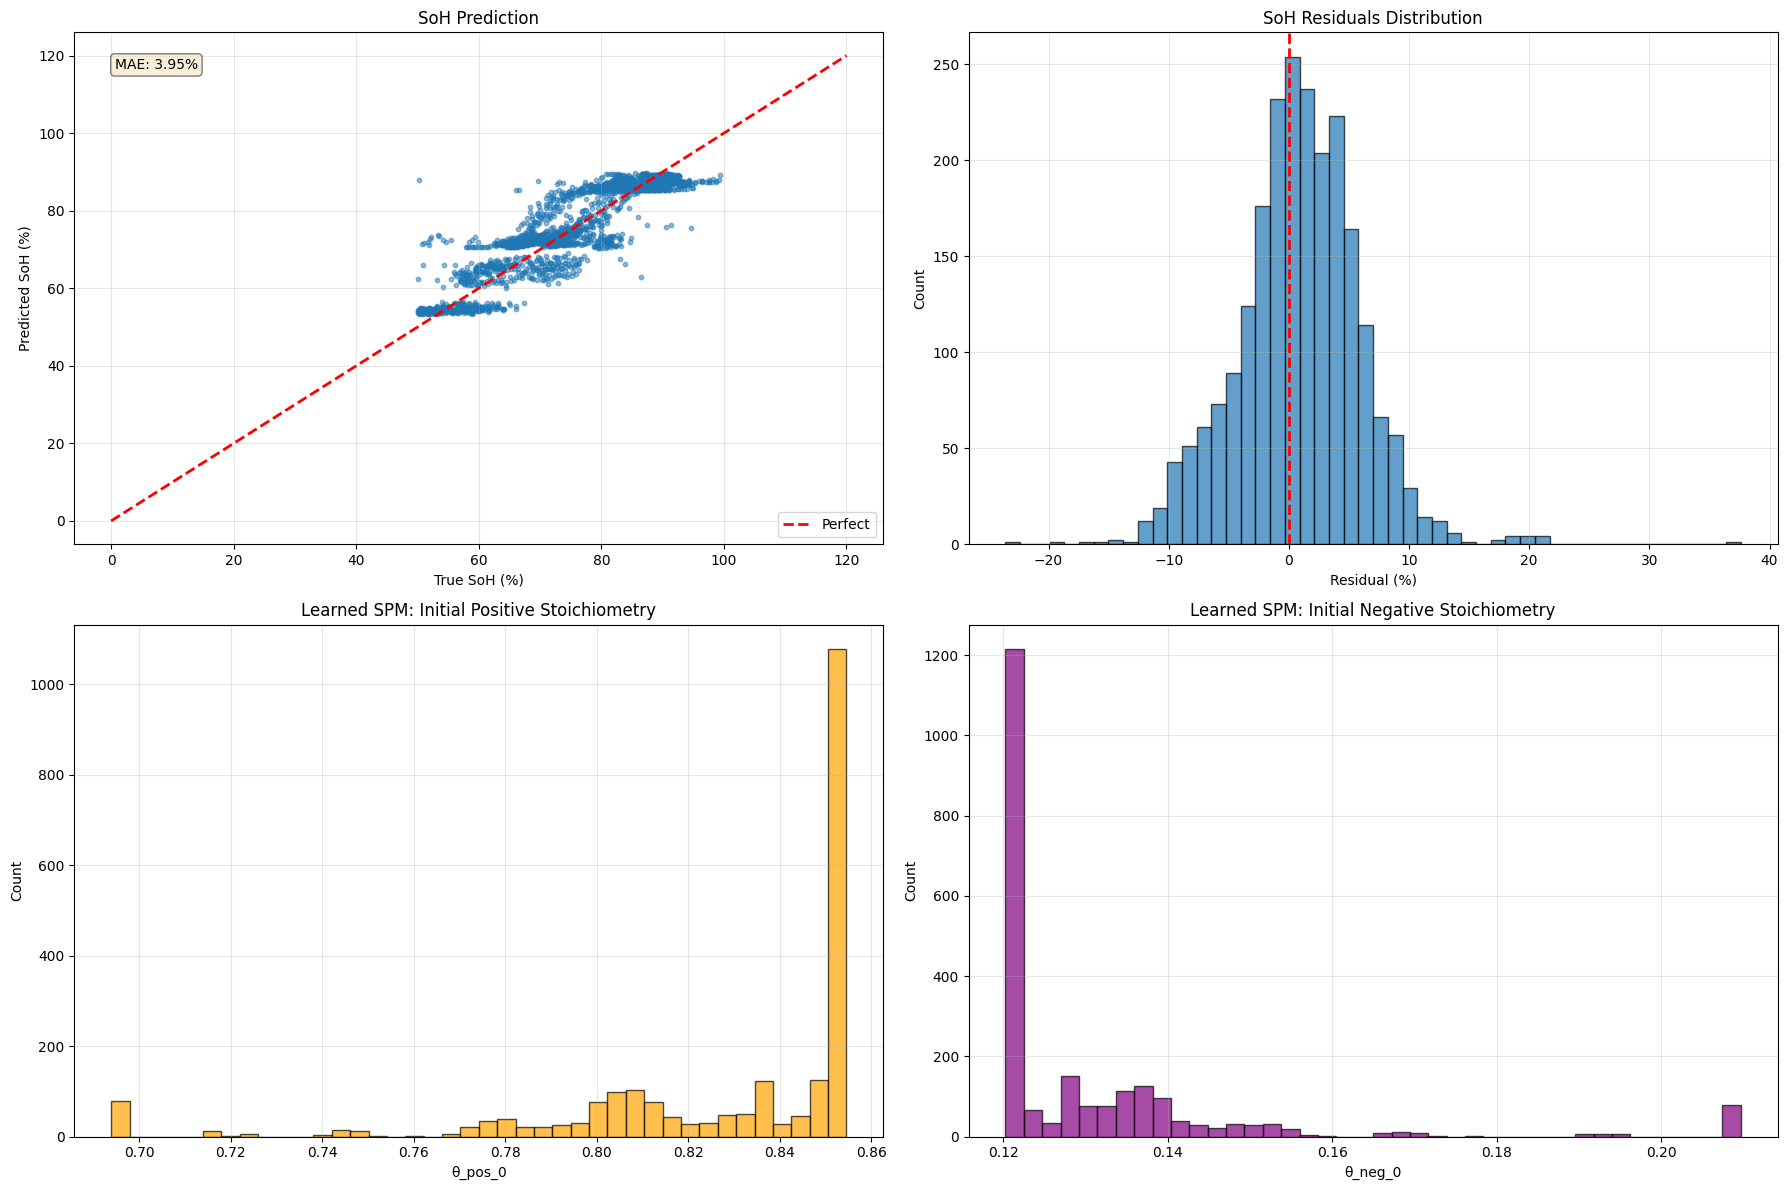

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# SoH prediction
axes[0, 0].scatter(y_soh_true * 100, y_soh_pred * 100, alpha=0.5, s=10)
axes[0, 0].plot([0, 120], [0, 120], 'r--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('True SoH (%)')
axes[0, 0].set_ylabel('Predicted SoH (%)')
axes[0, 0].set_title('SoH Prediction')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
mae_soh = np.mean(np.abs(y_soh_pred - y_soh_true) * 100)
axes[0, 0].text(0.05, 0.95, f'MAE: {mae_soh:.2f}%', transform=axes[0, 0].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# SoH residuals
residuals_soh = (y_soh_pred - y_soh_true) * 100
axes[0, 1].hist(residuals_soh, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residual (%)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('SoH Residuals Distribution')
axes[0, 1].grid(True, alpha=0.3)


# SPM parameters - Positive stoichiometry
axes[1, 0].hist(spm_params_collected['theta_pos_0'], bins=40, alpha=0.7, edgecolor='black', color='orange')
axes[1, 0].set_xlabel('θ_pos_0')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Learned SPM: Initial Positive Stoichiometry')
axes[1, 0].grid(True, alpha=0.3)

# SPM parameters - Negative stoichiometry
axes[1, 1].hist(spm_params_collected['theta_neg_0'], bins=40, alpha=0.7, edgecolor='black', color='purple')
axes[1, 1].set_xlabel('θ_neg_0')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Learned SPM: Initial Negative Stoichiometry')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Multiple Voltage Trajectories Comparison

## Save Final Results

In [80]:
results_df = pd.DataFrame({
    'SoH_true': y_soh_true * 100,
    'SoH_pred': y_soh_pred * 100,
    'SoH_error': residuals_soh,
    'R_total': spm_params_collected['R_total'],
    'theta_pos_0': spm_params_collected['theta_pos_0'],
    'theta_neg_0': spm_params_collected['theta_neg_0']
})

results_df.to_csv('physics_informed_results.csv', index=False)
print("Results saved to physics_informed_results.csv")
display(results_df.head(10))

Results saved to physics_informed_results.csv


,SoH_true,SoH_pred,SoH_error,R_total,theta_pos_0,theta_neg_0
0,59.885006,66.087791,6.202781,0.012496,0.850776,0.120602
1,53.826660,53.546494,-0.280166,0.012755,0.853810,0.121624
2,88.890312,89.273605,0.383288,0.023423,0.744249,0.169522
3,89.524612,89.251312,-0.273299,0.022908,0.746464,0.168038
4,79.388130,81.974289,2.586156,0.012604,0.834934,0.125827
5,66.765396,67.713348,0.947952,0.012514,0.849905,0.120770
6,73.570694,63.520630,-10.050064,0.012454,0.851978,0.120345
7,90.084587,89.339401,-0.745189,0.018176,0.775222,0.153866
8,55.668480,53.585632,-2.082849,0.012752,0.853803,0.121676
9,70.387070,71.904282,1.517206,0.012128,0.852577,0.121005


## Complete Data Flow Example

Let's trace **one discharge cycle** through the entire pipeline:

### 1️⃣ **Input: Battery Discharge Cycle**
- File: `00001.csv` (Battery B0047, discharge cycle)
- Raw data: ~1000 timesteps with V, I, T measurements
- True capacity: 1.674 Ah → **SoH = 83.7%** (1.674/2.0)

### 2️⃣ **Data Processing**
- **Resampling**: 1000 points → **200 uniform timesteps** (M_RESAMPLE)
- **Binning**: 200 points → **20 bins** (BINS) for Transformer input
- **Each bin** contains: avg(V, I, T, SoC), sum(dt)

### 3️⃣ **Transformer Forward Pass**
```
Input: [20 bins × 5 features] → Embedding → Transformer Encoder
         ↓
    Global pool (mean)
         ↓
    [SoH=0.837, Q_pred, E_pred, R_total=0.065Ω, θ_pos=0.72, θ_neg=0.25]
```

### 4️⃣ **SPM Physics Forward**
```
For each of 200 timesteps:
    θ_pos[t] = 0.72 + (1-SoC[t])*0.5 = 0.72 + delta
    θ_neg[t] = 0.25 - (1-SoC[t])*0.5 = 0.25 - delta
    
    V_ocv[t] = OCV_pos(θ_pos[t]) - OCV_neg(θ_neg[t])
              = 3.95V - 0.18V = 3.77V
    
    V_terminal[t] = V_ocv[t] - I[t] * R_total
                  = 3.77V - 2.0A * 0.065Ω = 3.64V
```

### 5️⃣ **Loss Computation**
```python
L_soh = MSE(0.837, 0.837_true) = 0.0001
L_q = MSE(Q_pred, Q_true) = 0.002
L_e = MSE(E_pred, E_true) = 0.003
L_physics = MSE(V_predicted[200], V_measured[200]) = 0.045
    ↑ Compares SPM voltage to real voltage at all 200 timesteps

L_total = L_soh + 0.05*L_q + 0.02*L_e + 0.5*L_physics
        = 0.0001 + 0.0001 + 0.00006 + 0.0225 = 0.023
```

### 6️⃣ **Backpropagation**
Gradients flow through:
- SPM equations (OCV curves, voltage equation)
- Resistance/stoichiometry heads
- Transformer encoder
- Updates model to minimize ALL losses simultaneously

## Conclusion

This notebook demonstrates a **Physics-Informed Neural Network (PINN)** approach that combines:

1. **Transformer Architecture**: For learning complex temporal patterns in battery data
2. **Single Particle Model (SPM)**: Physics-based differential equations for voltage prediction
3. **Multi-Task Learning**: Simultaneous prediction of SoH, capacity, energy, and SPM parameters
4. **Physics Loss**: Differential equation residuals ensure physical consistency

### Key Advantages:
- More robust predictions by incorporating physical constraints
- Interpretable SPM parameters (resistance, stoichiometry)
- Better generalization through physics regularization
- Voltage trajectory prediction capability
